In [1]:
import joblib
import pandas as pd
import numpy as np
import logging

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def load_data(work_computer=False):
    if work_computer:
        path = "/cumulus/edeno/non_local_paper/notebooks/"
    else:
        path = "/Users/edeno/Downloads/"

    position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
    spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
    is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
    env = joblib.load(path + "Jaq_03_16_environment.pkl")

    time = np.asarray(position_info.index / np.timedelta64(1, "s"))
    spikes = np.asarray(spikes).astype(float)
    position = np.asarray(position_info.linear_position).astype(float)
    is_ripple = np.asarray(is_ripple).squeeze()
    speed = np.asarray(position_info.nose_vel).astype(float)

    return is_ripple, spikes, position, speed, env, time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
is_ripple, spikes, position, speed, env, time = load_data(work_computer=False)

26-Jun-23 11:49:47 Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/Users/edeno/miniconda3/envs/non_local_detector/lib/python3.11/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from non_local_detector import NonLocalSortedSpikesDetector

detector = NonLocalSortedSpikesDetector(
    environments=env,
    sorted_spikes_algorithm_params={
        "position_std": 6.0,
        "use_diffusion": False,
        "block_size": 10_000,
        "interpolate_local": False,
    },
).fit(position, spikes, is_training=~is_ripple)

26-Jun-23 11:49:49 Fitting initial conditions...
26-Jun-23 11:49:49 Fitting discrete state transition
26-Jun-23 11:49:49 Fitting continuous state transition...
26-Jun-23 11:49:49 Fitting place fields...
26-Jun-23 11:49:49 Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
26-Jun-23 11:49:49 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
26-Jun-23 11:49:49 Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
26-Jun-23 11:49:49 Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


Encoding models:   0%|          | 0/104 [00:00<?, ?cell/s]

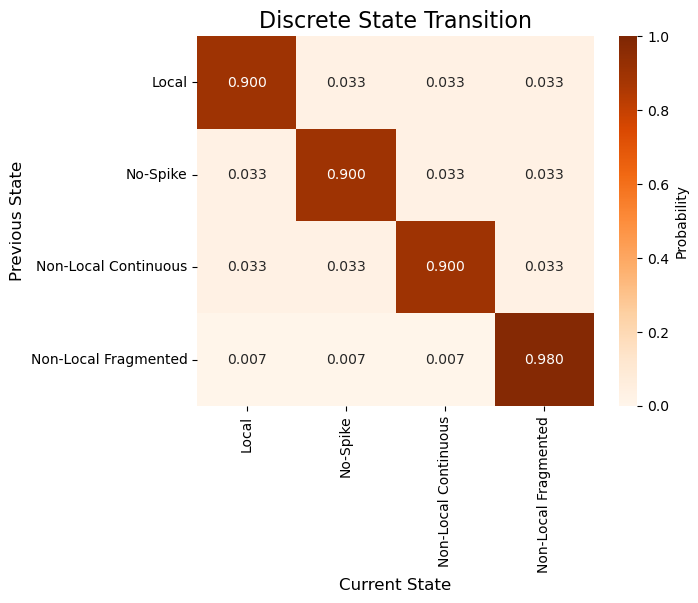

In [4]:
detector.plot_discrete_state_transition()

In [5]:
results = detector.predict(spikes, position, time=time)
results

26-Jun-23 11:49:55 Computing log likelihood...


Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

26-Jun-23 11:54:46 Computing posterior...
26-Jun-23 11:54:59 Finished computing posterior...


<xarray.Dataset>
Dimensions:                      (time: 452325, state_bins: 404, states: 4,
                                  state_ind: 404)
Coordinates:
  * time                         (time) float64 2.239e+04 ... 2.329e+04
  * state_bins                   (state_bins) object MultiIndex
  * state                        (state_bins) object 'Local' ... 'Non-Local F...
  * position                     (state_bins) float64 nan nan ... 420.7 422.7
  * state_ind                    (state_ind) int64 0 1 2 2 2 2 2 ... 3 3 3 3 3 3
  * states                       (states) <U20 'Local' ... 'Non-Local Fragmen...
    environments                 (states) <U1 '' '' '' ''
    encoding_groups              (states) int64 0 0 0 0
Data variables:
    acausal_posterior            (time, state_bins) float32 1.0 0.0 ... 0.002966
    acausal_state_probabilities  (time, states) float64 1.0 0.0 ... 0.2649
Attributes:
    marginal_log_likelihoods:  -1921614.6

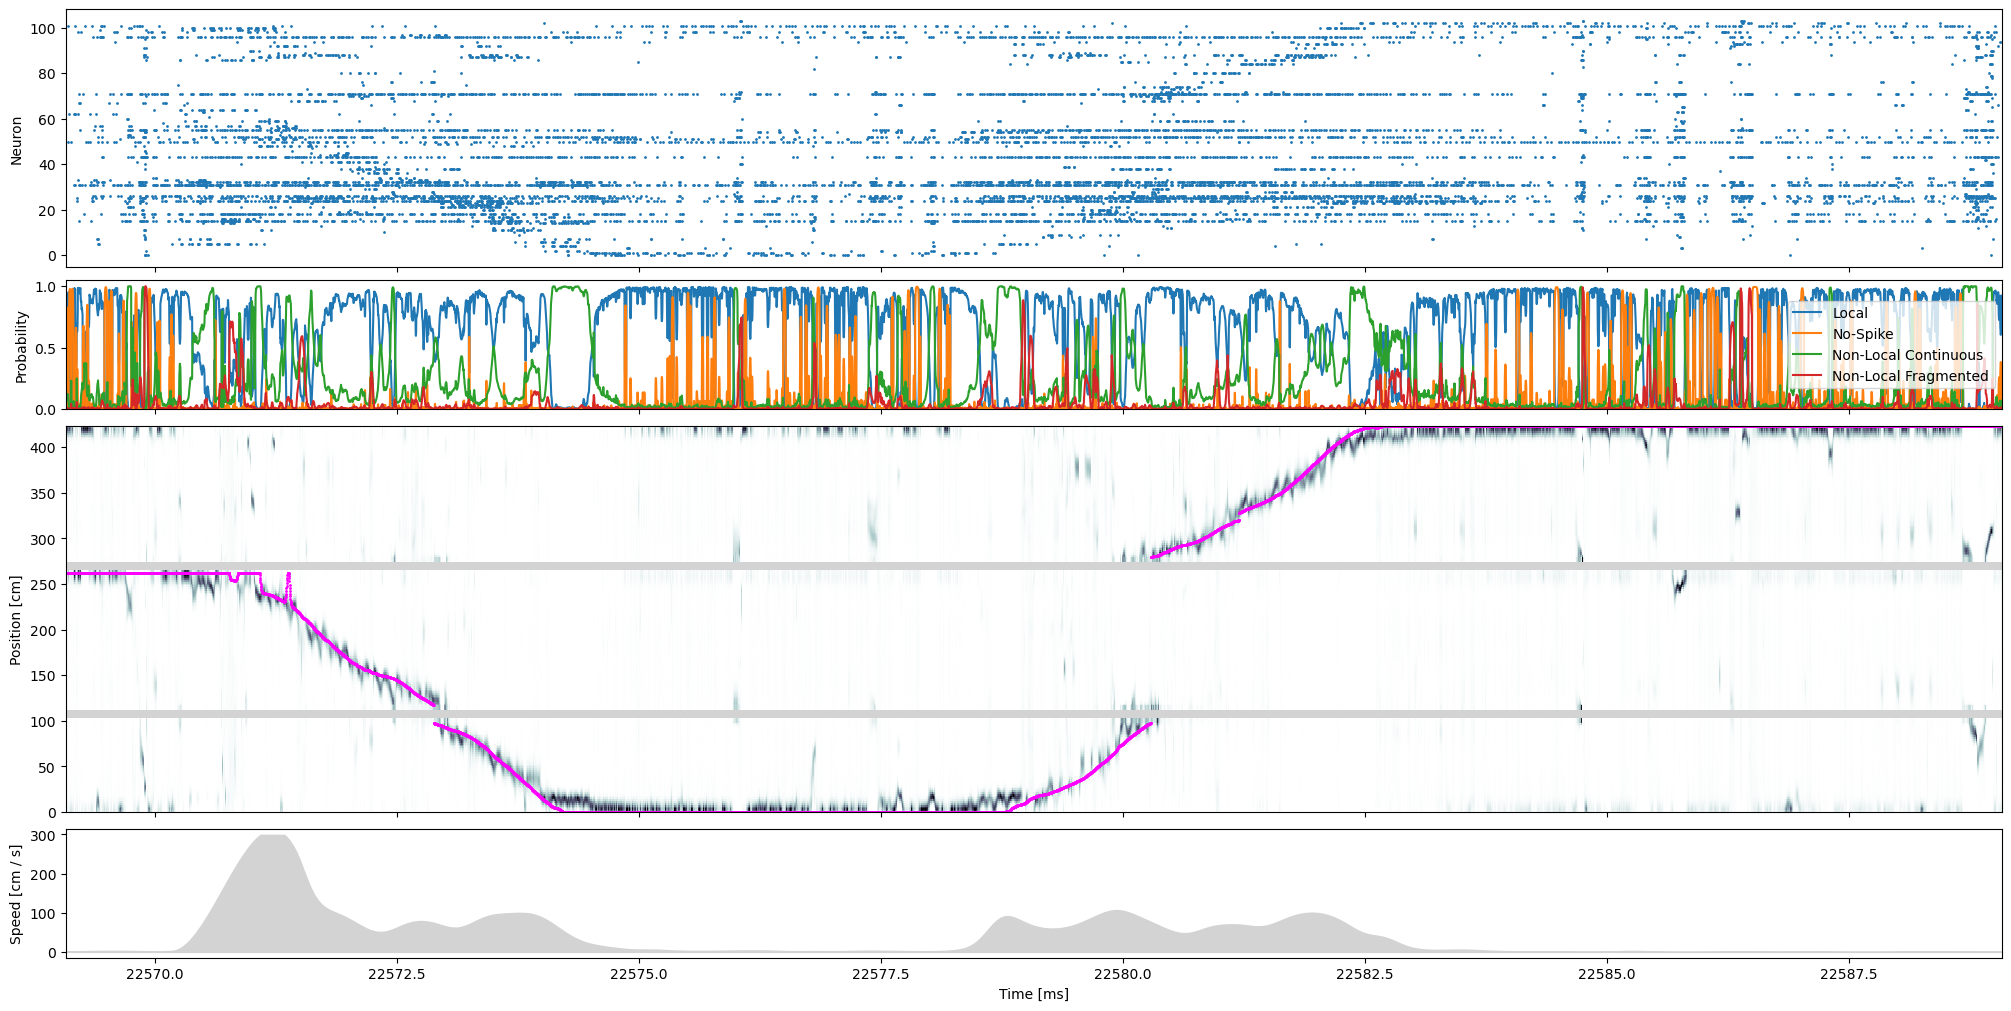

In [6]:
from non_local_detector.visualization import plot_non_local_model

plot_non_local_model(
    time,
    position,
    spikes,
    speed,
    detector,
    results,
    time_slice=slice(90_000, 100_000),
    figsize=(20, 10),
)

In [7]:
results = detector.estimate_parameters(spikes, position, time=time)

26-Jun-23 11:55:05 Fitting initial conditions...
26-Jun-23 11:55:05 Fitting discrete state transition
26-Jun-23 11:55:05 Fitting continuous state transition...
26-Jun-23 11:55:06 Fitting place fields...


Encoding models:   0%|          | 0/104 [00:00<?, ?cell/s]

26-Jun-23 11:55:11 Computing log likelihood...


Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

26-Jun-23 12:00:11 Expectation step...
26-Jun-23 12:00:11 Computing posterior...
26-Jun-23 12:00:24 Finished computing posterior...
26-Jun-23 12:00:24 Maximization step..
26-Jun-23 12:00:24 Computing stats..
26-Jun-23 12:00:24 iteration 1, likelihood: -1927114.875
26-Jun-23 12:00:24 Expectation step...
26-Jun-23 12:00:24 Computing posterior...
26-Jun-23 12:00:37 Finished computing posterior...
26-Jun-23 12:00:37 Maximization step..
26-Jun-23 12:00:37 Computing stats..
26-Jun-23 12:00:37 iteration 2, likelihood: -1909971.25, change: 17143.625
26-Jun-23 12:00:37 Expectation step...
26-Jun-23 12:00:37 Computing posterior...
26-Jun-23 12:00:51 Finished computing posterior...
26-Jun-23 12:00:51 Maximization step..
26-Jun-23 12:00:51 Computing stats..
26-Jun-23 12:00:51 iteration 3, likelihood: -1907951.0, change: 2020.25
26-Jun-23 12:00:51 Expectation step...
26-Jun-23 12:00:51 Computing posterior...
26-Jun-23 12:01:04 Finished computing posterior...
26-Jun-23 12:01:04 Maximization step..
2

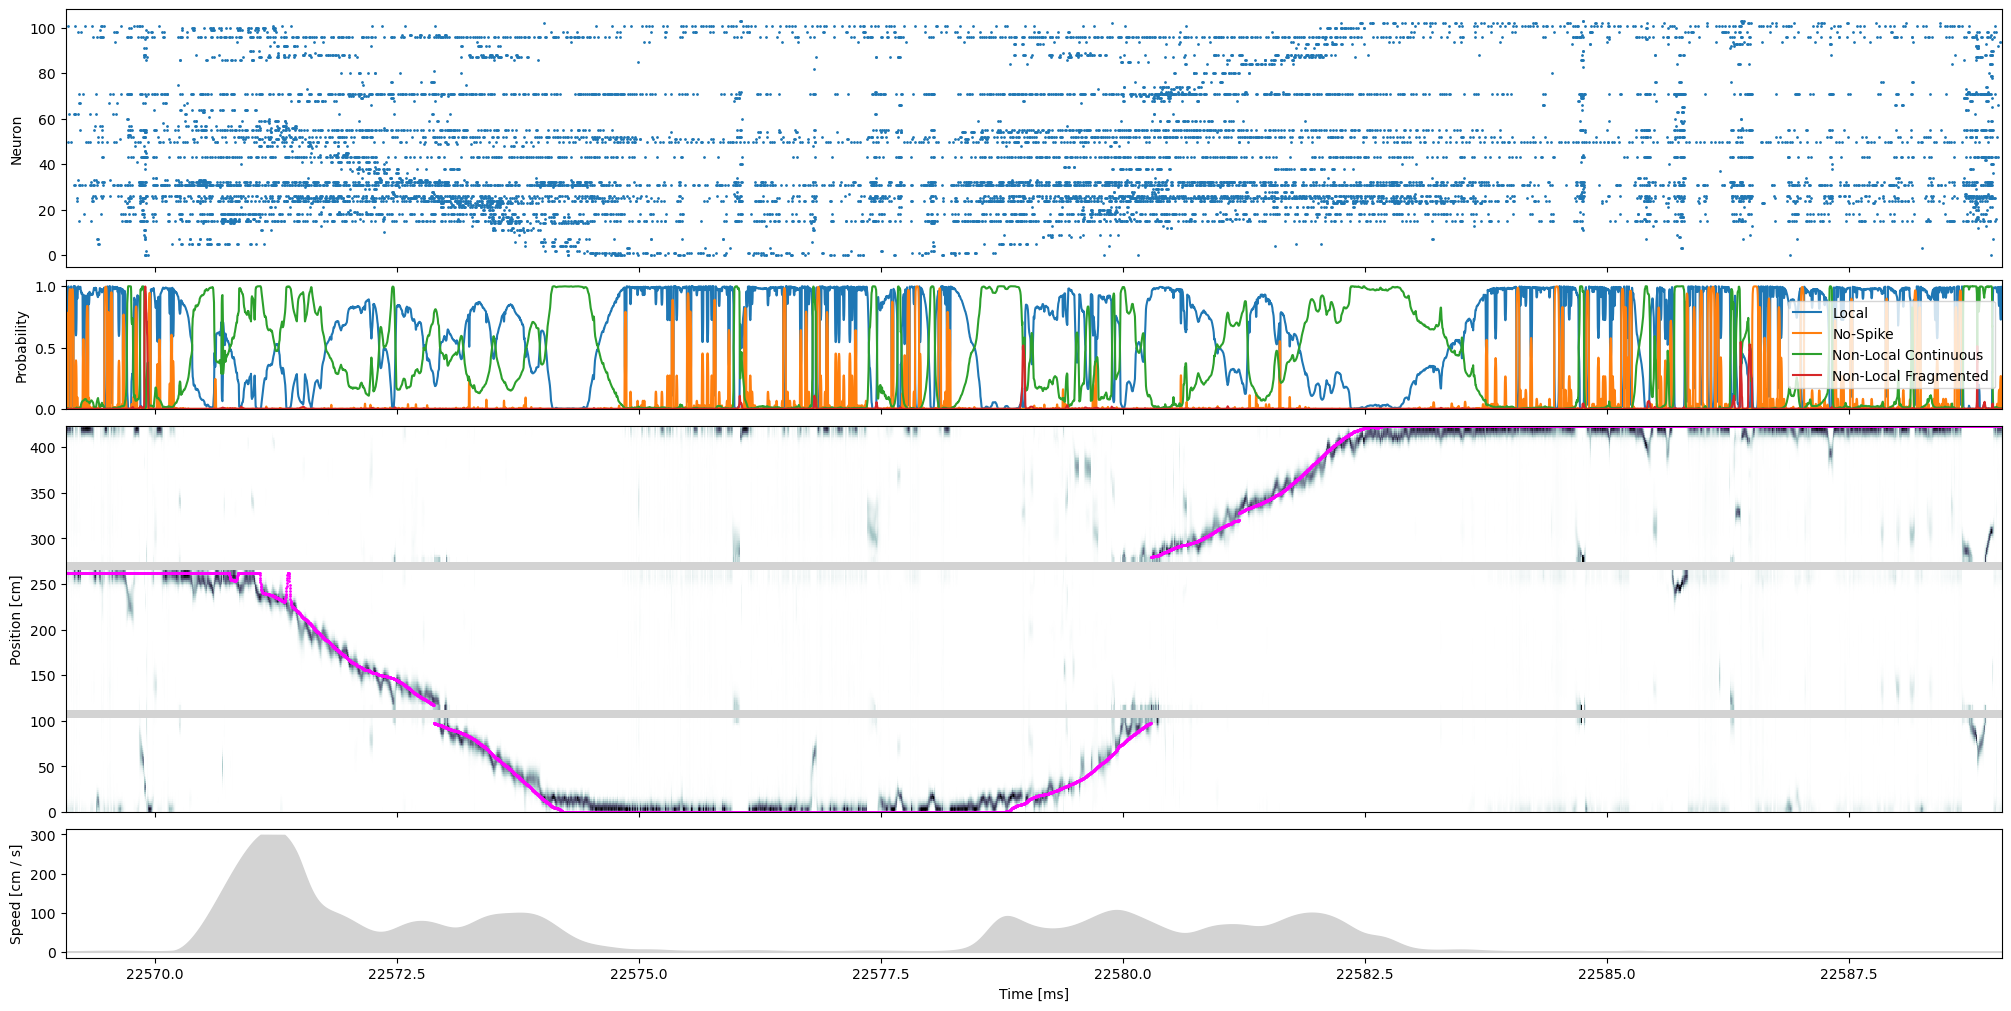

In [8]:
from non_local_detector.visualization import plot_non_local_model

plot_non_local_model(
    time,
    position,
    spikes,
    speed,
    detector,
    results,
    time_slice=slice(90_000, 100_000),
    figsize=(20, 10),
)

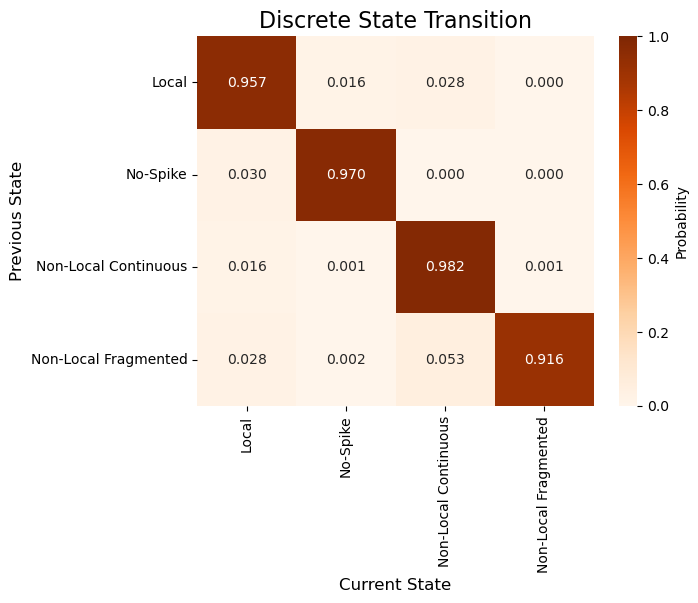

In [9]:
detector.plot_discrete_state_transition()